# Tracking Beam Center Drift

__Goal:__ Analyze how the center of the data drifts with respect to lab time. To do this, we will average images based on file number and find the center for each group. 

__Note:__ 
* No data processing is done except for applying a mask. 
* Group size can be set manually
* Occasionally the center finding fails and returns (0,0) when this happens the center for that group is replaced with the average value of the centers

## Import necessary Packages

In [16]:
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib widget

import os
from multiprocessing.dummy import Pool as ThreadPool

## Define Functions

### Loading Data

In [44]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in 
            file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names, sort=True):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                folder_number = int(string[9][-3:])
                string = list(map(str, string[-1].split("-")))
                file_number = folder_number*100 + int(string[1])
                file_order.append(int(file_number))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    
    return data_array, stage_pos, file_order, counts 

def get_image_details_slac(file_names, sort=True):
    """
    WORKS FOR CURRENT DATA COLLECTION
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    Arguments:
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken.
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.
    """
    data_array = tf.imread(file_names) # construct array containing files
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("_")))
                file_order.append(int(string[2]))
                stage_pos.append(float(string[3]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    counts = get_counts(data_array)
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
        counts = counts[idx_sort]
    return data_array, stage_pos, file_order, counts

def normalize_to_baseline(data):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[80:200])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, 80:200])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

In [46]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files[:100])
counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position

print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(file_numbers)

Load diffraction signal
Image number read:  100
Stage positions:  37
[ 301  302  303  304  305  306  307  308  309  310  311  312  313  314
  315  316  317  318  319  320  321  322  323  324  325  326  327  328
  329  330  331  332  333  334  335  336  337  901  902  903  904  905
  906  907  908  909  910  911  912  913  914  915  916  917  918  919
  920  921  922  923  924  925  926  927  928  929  930  931  932  933
  934  935  936  937 3101 3102 3103 3106 3107 3111 3112 3115 3116 3118
 3119 3120 3121 3122 3124 3125 3126 3127 3128 3129 3130 3131 3132 3134
 3136 3137]
CPU times: user 156 ms, sys: 110 ms, total: 266 ms
Wall time: 334 ms


### Masking Beam Block

In [18]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [19]:
def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    # fit_value=average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    fit_value= np.average([I[round(center[0])+r][round(center[1])],I[round(center[0])-r][round(center[1])],I[round(center[0])][round(center[1])+r],I[round(center[0])][round(center[1])-r]])

    [X_f,Y_f]= np.where((I>0.999*fit_value) & (I<1.001*fit_value))

    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
            
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A= np.empty((len(fit_points[0]),3)) # Find center for 3 thimes
    B= np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=sum((np.dot(A,par)-y_ave)**2)/sum((B-y_ave)**2)
        print(r2)
    
    center_new=[(-par[0]/2),(-par[1]/2)] # no-Round the center, not working for the moment
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2) # no-round the r range, not working for the moment
    # print('ct found:'+str(center_new))
    
    # center_new=[round(-par[0]/2),round(-par[1]/2)] # Round the center
    # r_new=round(sqrt(par[0]**2+par[1]**2-4*par[2])/2) # round the r range
    
    return center_new,r_new


### Azimuthal Averaging

In [20]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

def get_average_old(array):
    """Return the average and standard deviation of an array"""
    Sum = 0
    Sum_squared = 0
    for element in array:
        if element == None:
            continue # Skip empty values
        Sum += element
        Sum_squared += element**2
    length = len(array)
    if length == 0:
        return 0, 0
    average = Sum / length 
    stdev = sqrt(Sum_squared / length - average**2) # sigma^2 = <X^2> - <X>^2
    return average, stdev

def get_average(array):
    average = np.nanmean(array)
    stdev = np.nanstd(array)
    return average, stdev

def get_radial_distribution(image):
    """Get average radial intensity after eliminating outliers"""
    radial_range = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER)) #half the size of the image i.e. 512 for 1024 by 1024 image
    radial_values = [[] for r in range(radial_range)]
    # First get all pixel values for each radial position as an array that we can average over later
    # It will look like
    #   [ (R = 0 values) [...],
    #     (R = 1 values) [...],
    #     (R = 2 values) [...], etc ]

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            R_index = int(round(R))
            if R_index < len(radial_values):
                radial_values[R_index].append(image[X][Y])
    # So now we have an array where, for each R value, we have a sub-array of each pixel intensity at that R
    # We want to first calculate the average and standard deviation
    # Then eliminate all outliers that are >3sigma away from the average
    # Then re-calculate the average with all outliers removed
    radial_averages, radial_stdevs = [], []
    for r_values in radial_values:
        avg, stdev = get_average(r_values)
        # Create new list with outliers removed
        new_r_values = [r if abs(avg - r) <= 5*stdev else np.nan for r in r_values]
        new_avg, new_stdev = get_average(new_r_values)
        radial_averages.append(new_avg)
        radial_stdevs.append(new_stdev)
    
    return radial_averages, radial_stdevs

def remove_radial_outliers(image):
    """After finding average radial values, replace all outlier pixels with the average value at that radius"""
    radial_avgs, radial_stdevs = get_radial_distribution(image)

    new_image = [[0 for Y in range(GRID_SIZE)] for X in range(GRID_SIZE)] # image of all zeros

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            # Calculate the interpolated value for the average and stdev at this R
            # (Same thing I do in simulate_image but now I'm calculating the weighted average of the 
            # average intensity values so the language is a little confusing)
            interpolated_avg, interpolated_stdev = 0, 0 # Will be filled in with the interpolated values

            R_lower = floor(R)
            R_upper = R_lower + 1
            if R_lower >= len(radial_avgs):
                interpolated_avg = 0 # R value is out of bounds, default to 0
                interpolated_stdev = 0
            elif R_upper >= len(radial_avgs):
                interpolated_avg = radial_avgs[R_lower] # R value is just outside of bounds, default to edge value
                interpolated_stdev = radial_stdevs[R_lower]
            else:
                # Calculate weighted average
                interpolated_avg = (R - R_lower) * radial_avgs[R_upper] + (R_upper - R) * radial_avgs[R_lower]
                interpolated_stdev = (R - R_lower) * radial_stdevs[R_upper] + (R_upper - R) * radial_stdevs[R_lower]
            
            if abs(image[X][Y] - interpolated_avg) <= 3*interpolated_stdev:
                # Value is within acceptance range, do not change
                new_image[X][Y] = image[X][Y] 
            else:
                # Value is outside acceptance range, use average value instead
                new_image[X][Y] = interpolated_avg
    
    return new_image

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [24]:
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
# #dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349'
runPath = "/*/*/ANDOR1_*.tif"

#dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231212/Run/20231212_2046/'
#dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231213/Run/20231213_1636'
# dataPath = '/sdf/data/lcls/ds/ued_testfac/data/ueduu10004/NMP/20231214/Run/20231214_2303/'
# runPath = '/*/ANDOR1_*.tif'


#bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
#print(bkg_path)

files = glob.glob(newPath) 
#bkg_files = glob.glob(bkg_path)
print(files[0:37])
#print(len(bkg_files))

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/*/*/ANDOR1_*.tif
['/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-007-110.1700_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-006-108.7800_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-022-108.0100_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-026-108.9700_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-032-108.0000_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-018-108.6200_0001.tif', '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_03

### Plotting Example Image

Load a image to check the signal level: /work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-007-110.1700_0001.tif
Total number of images in the chosen directory is 1998


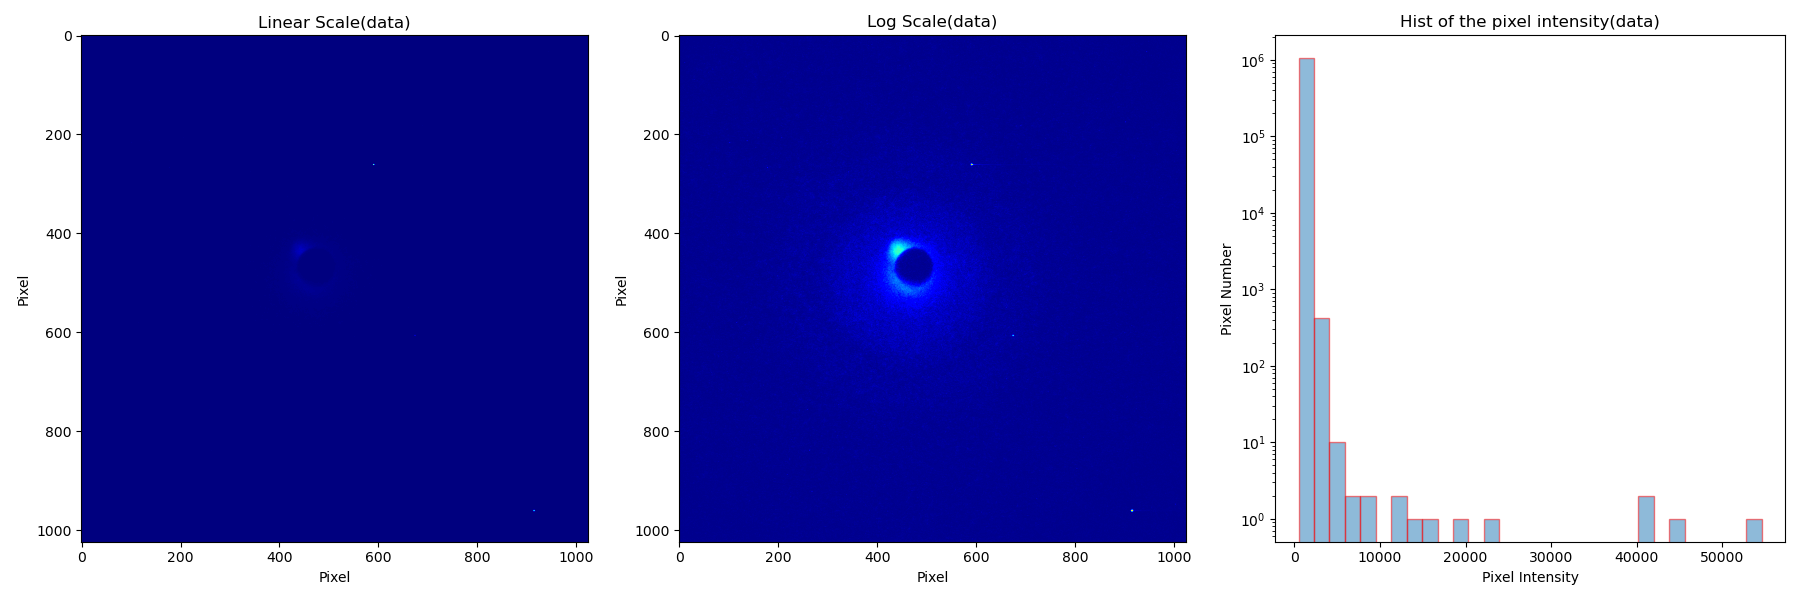

In [25]:
test=tf.imread(files[0]);
bkg_sign='no'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(18,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [26]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files[:10])
counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position

print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(file_numbers)

Load diffraction signal
Image number read:  10
Stage positions:  10
[ 7  6 22 26 32 18 15 19  2 29]
CPU times: user 15.9 ms, sys: 8.41 ms, total: 24.3 ms
Wall time: 30.7 ms


### Visualizing Data Info

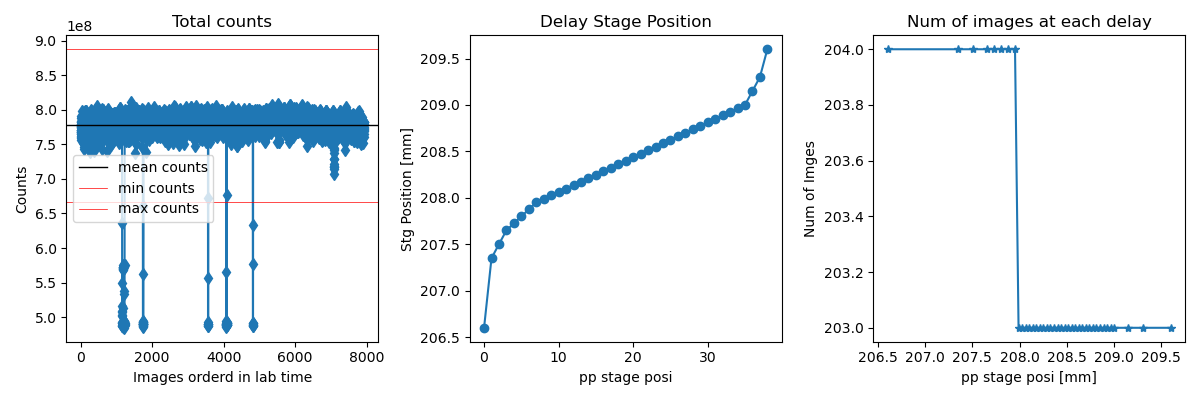

In [92]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Filtering Out Bad Shots Based on Total Counts

In [93]:
# Decide to use threshold or selected images
#test_data = good_data
remove_std = True 
if remove_std is True:
    # Auto find out the bad images by filtering on the total counts
    tc_good = np.squeeze(np.where(abs(counts-counts_mean)<1*counts_std)) # Find out the indices of the low counts images
    good_data = test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]
    good_files = file_numbers[tc_good]
else:
    # Manual find out the bad images by checking the tc from last figure
    tc_good = np.concatenate((np.arange(0, 923, 1), np.arange(926, 1319, 1), np.arange(1322, 2113, 1), np.arange(2261, len(test_data), 1)))
    good_data=test_data[tc_good]
    good_stage = np.squeeze(stage_positions[tc_good])
    good_counts = counts[tc_good]

print(len(good_data))



7778


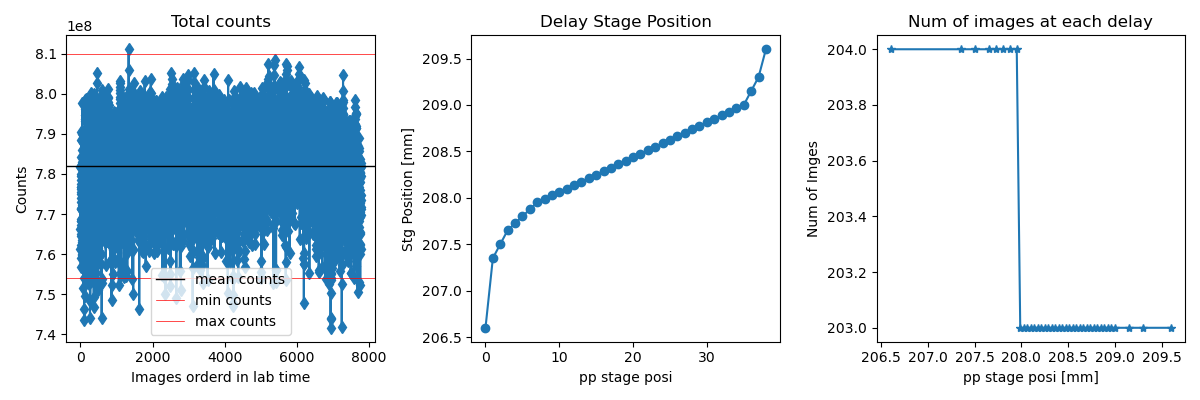

In [94]:
counts_mean = np.mean(good_counts)
counts_std = np.std(good_counts)

fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(good_counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

del test_data
del stage_positions
del file_numbers

## Averaging Based on Image Number

In [76]:
grp_sz = 100
groups = np.arange(0, len(good_files)+1, grp_sz)
data = []
image_number = []
for i in range(len(groups)-1):
    ave_data = np.mean(good_data[groups[i]:groups[i+1]], axis=0)
    print("Averaging group: ", groups[i], "-", groups[i+1])
    data.append(ave_data)
    image_number.append(good_files[groups[i]])
    
data = np.array(data)
print(data.shape)

Averaging group:  0 - 100
Averaging group:  100 - 200
Averaging group:  200 - 300
Averaging group:  300 - 400
Averaging group:  400 - 500
Averaging group:  500 - 600
Averaging group:  600 - 700
Averaging group:  700 - 800
Averaging group:  800 - 900
Averaging group:  900 - 1000
Averaging group:  1000 - 1100
Averaging group:  1100 - 1200
Averaging group:  1200 - 1300
Averaging group:  1300 - 1400
Averaging group:  1400 - 1500
Averaging group:  1500 - 1600
Averaging group:  1600 - 1700
Averaging group:  1700 - 1800
Averaging group:  1800 - 1900
Averaging group:  1900 - 2000
Averaging group:  2000 - 2100
Averaging group:  2100 - 2200
Averaging group:  2200 - 2300
Averaging group:  2300 - 2400
Averaging group:  2400 - 2500
Averaging group:  2500 - 2600
Averaging group:  2600 - 2700
Averaging group:  2700 - 2800
Averaging group:  2800 - 2900
Averaging group:  2900 - 3000
Averaging group:  3000 - 3100
Averaging group:  3100 - 3200
Averaging group:  3200 - 3300
Averaging group:  3300 - 3400
A

## Masking Beam Block

Uses `opencv.HoughCircles` to find the circular mask on the image.  
We use the function: cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)

__Parameters:__
 - `image` 8-bit, single-channel, grayscale input image.
 - `circles` output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
 - `method` detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
 - `dp` inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
 - `minDist` minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
 - `param1` first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
 - `param2` second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
 - `minRadiu` minimum circle radius.
 - `maxRadius` maximum circle radius.

__Note:__ only works after averaging for each stage position. Too large of data sets causes jupyter to crash. Will trouble shoot this later...

### Find Mask Location

In [77]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(data,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.9, minRadius=30, maxRadius=60))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));
#stage_ave = stage_ave*mask
#good_data = good_data*mask

The hole center at [526.5 513. ] with radius [46.27134]


### Apply Mask

In [78]:
#hole_center = (477.0, 465.0)
hole_center = hole[0], hole[1]
print(hole_center)
inner_radius = float(hole[2])
print(inner_radius)
outer_radius = 575
data_ave_raw = np.mean((data),axis=0); 
ring_mask_data = detectorMask(data, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

data = ring_mask_data

(526.5, 513.0)
46.271339416503906
(73, 1024, 1024)


### Apply additional mask

(450.0, 440.0)
46.4232063293457
(20, 1024, 1024)


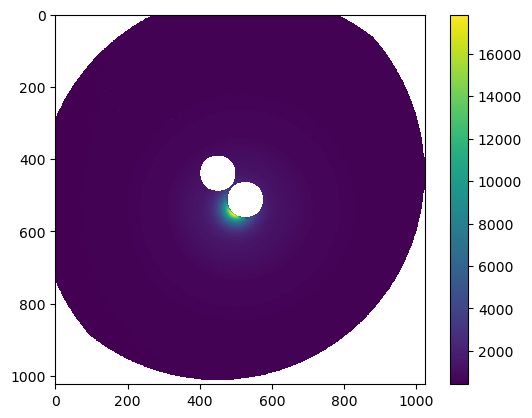

In [12]:
hole_center = (450.0, 440.0)
#hole_center = hole[0], hole[1]
print(hole_center)
inner_radius = float(hole[2])
print(inner_radius)
outer_radius = 575
data_ave_raw = np.mean((data),axis=0); 
ring_mask_data = detectorMask(data, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

data = ring_mask_data

## Finding Diffraction Center

In [79]:
%%time

x_centers = []
y_centers = []
for i in range(len(data)):
    center = find_beam_center(data[i],center=[500,500],r=150)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1==0:
        print('Found center of ' + str(center)+' of group ' + str(i))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [544.1461462881931, 501.36753820683276] of group 0
Found center of [543.9981214452832, 501.42648315293854] of group 1
Found center of [544.0495515959293, 501.7137296192407] of group 2
Found center of [544.0404644660185, 502.12644663593574] of group 3
Found center of [543.9904937096603, 501.79095269737843] of group 4
Found center of [544.0049362149364, 501.8298058602878] of group 5
Found center of [543.8201189960314, 502.17009980457783] of group 6
Found center of [543.9990959469736, 502.2652181423452] of group 7
Found center of [544.5749808917282, 501.4533739195419] of group 8
Found center of [543.929270826, 501.90556014381343] of group 9
Found center of [544.1451768526083, 501.46006539660783] of group 10
Found center of [544.5447314183407, 502.1977170400892] of group 11
Found center of [544.591323435194, 501.1055303449316] of group 12
Found center of [543.8505957961561, 502.11326860895235] of group 13
Found center of [544.4022071543302, 501.72050002267895] of group 14
F

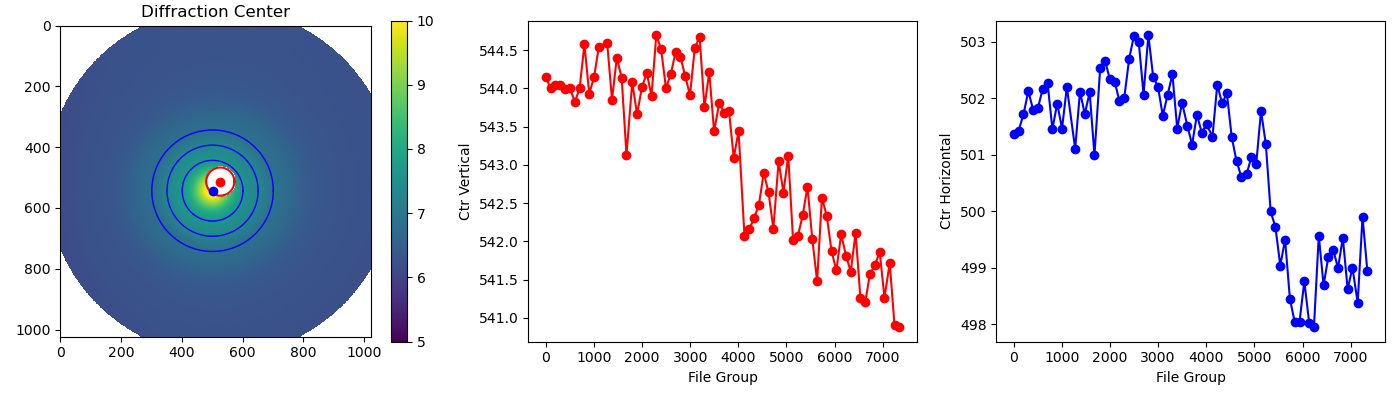

In [80]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(data, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(image_number,centers[0],'-or');
plt.xlabel('File Group');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(image_number,centers[1],'-ob');
plt.xlabel('File Group');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

In [81]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
#X_CENTER = 539
#Y_CENTER = 505
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(data, x, y)

max Q index is 480


/tmp/ipykernel_3853086/1622898995.py:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/tmp/ipykernel_3853086/1622898995.py:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


/tmp/ipykernel_3853086/3422412568.py:221: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


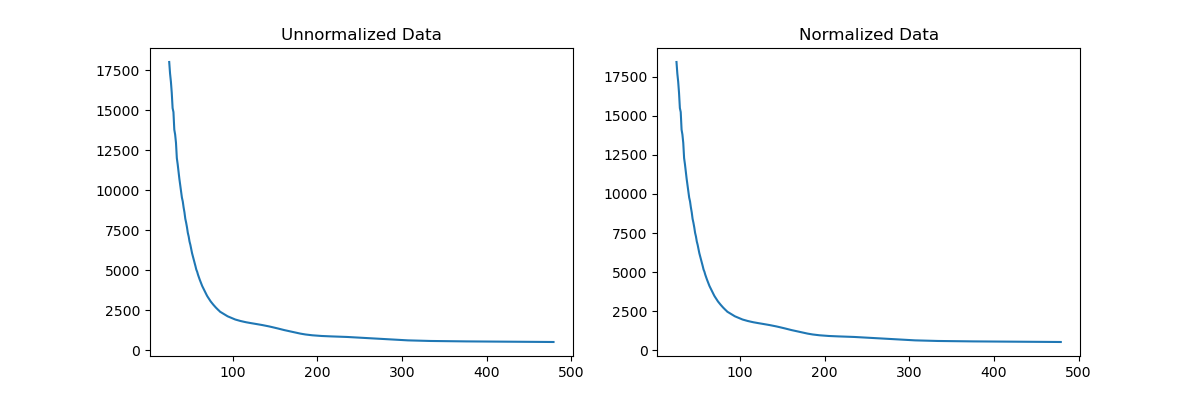

In [82]:
norm_data = normalize_to_baseline(azi_data) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_data[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

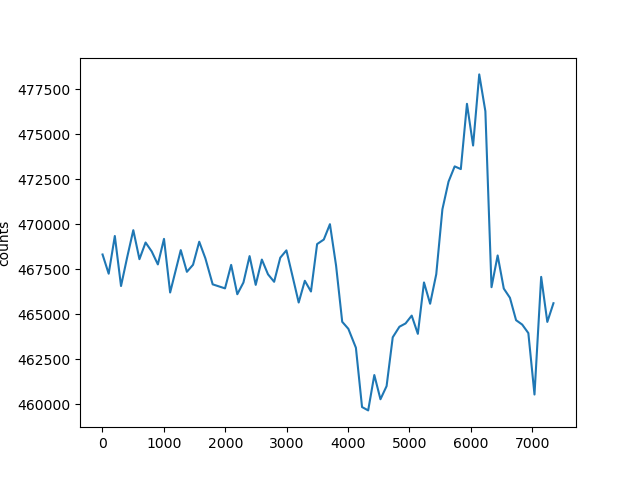

In [83]:
low_q = []
for i in range(len(norm_data)):
    q = np.sum(norm_data[i, 25:100])
    low_q.append(q)
    
low_q = np.array(low_q)

plt.figure()
plt.plot(image_number, low_q)
plt.ylabel("counts")
plt.show()